In [1]:
# Import The Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Import The Dataset
df = pd.read_csv('/Users/rezigibtissam/Downloads/KaDo.csv')
df = df[df['CLI_ID'].notna()]

In [3]:
#Create The RFM Table

In [4]:
arg = df.groupby(['CLI_ID', 'LIBELLE']).agg({'LIBELLE':list, 'PRIX_NET': 'sum', 'MOIS_VENTE': 'max'})
arg['Quantity'] = arg['LIBELLE'].str.len()
del arg['LIBELLE']

In [5]:
arg["TotalSum"] = arg["Quantity"] * arg["PRIX_NET"]

In [6]:
arg.rename(columns = {'MOIS_VENTE': 'Recency',
                        'Quantity': 'Frequency',
                        'TotalSum': 'Monetary'}, inplace=True)
del arg['PRIX_NET']

In [7]:
arg

Recency  Frequency  Monetary
CLI_ID    LIBELLE                                                             
1490281   CR JR PARF BIO.SPE AC.SENT.50ML              10          1      7.45
          EAU MICELLAIRE 3 THES FL200ML                10          1      5.95
          GD JDM4 PAMPLEMOUSSE FL 200ML                10          2      6.66
          GD JDM4 TIARE FL 200ML                       10          1      1.67
13290776  EDT  UN MATIN AU JARDIN  100ML  MUGUET        9          1     13.00
...                                                   ...        ...       ...
997385337 VAO BRIL ROSE SOMPTUEUX 14 CN3 5.5ML          6          1      4.45
          VAO BRIL ROUG/SIENN 33 AX/SO CN3 5,5ML        9          1      4.45
          VAO HIBISCUS ROUGE ETE13 ANI LU4 3ML          5          1      3.90
          VAO PASTEL PARME 03 MANUC CN3 5.5ML           9          1      8.90
          ZERO TRACE SPRAY SPF 15 FL150                 9          1      9.95

[5911149 rows x 3 columns]

In [8]:
arg.head()

Recency  Frequency  Monetary
CLI_ID   LIBELLE                                                             
1490281  CR JR PARF BIO.SPE AC.SENT.50ML              10          1      7.45
         EAU MICELLAIRE 3 THES FL200ML                10          1      5.95
         GD JDM4 PAMPLEMOUSSE FL 200ML                10          2      6.66
         GD JDM4 TIARE FL 200ML                       10          1      1.67
13290776 EDT  UN MATIN AU JARDIN  100ML  MUGUET        9          1     13.00

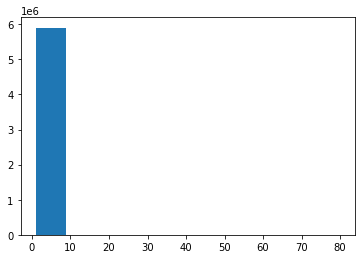

In [9]:
plt.hist(arg['Frequency'], bins=10)
plt.show()

In [10]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(arg['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(arg['Frequency'])[0]
customers_fix["Monetary"] = pd.Series(np.cbrt(arg['Monetary'])).values
customers_fix.tail()

,Recency,Frequency,Monetary
5911144,4.387815,0.0,1.644826
5911145,6.769914,0.0,1.644826
5911146,3.565543,0.0,1.574061
5911147,6.769914,0.0,2.072351
5911148,6.769914,0.0,2.150838


In [11]:
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0.  0. -0.]
[1. 1. 1.]


In [12]:
customers_normalized

array([[ 0.80763719, -0.40168843,  0.08144337],
       [ 0.80763719, -0.40168843, -0.08709141],
       [ 0.80763719,  2.48587698, -0.00416512],
       ...,
       [-0.55667816, -0.40168843, -0.37153532],
       [ 0.54272214, -0.40168843,  0.22399736],
       [ 0.54272214, -0.40168843,  0.31780112]])

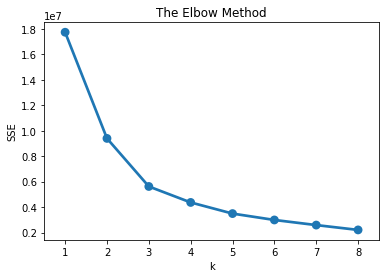

In [13]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [14]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(5911149,)

In [15]:
arg["Cluster"] = model.labels_
arg.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary         
           mean      mean     mean    count
Cluster                                    
0          9.71      1.00     5.66  2742343
1          8.66      2.62    54.01   821345
2          3.54      1.00     6.19  2347461

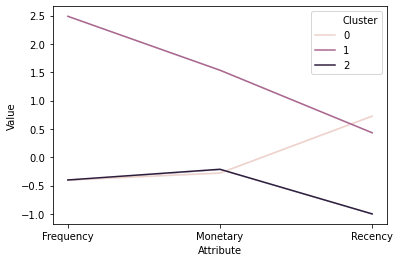

In [16]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['ID'] = arg.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)